# Fitting including the line spread function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.ndimage import gaussian_filter1d
from copy import deepcopy

from astropy.modeling import models, fitting
import sys
sys.path.append('../')
import sagan

from scipy.ndimage import gaussian_filter1d

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

/Users/shangguan/Softwares/my_modules/SAGAN/sagan/stellar_continuum.py:311: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


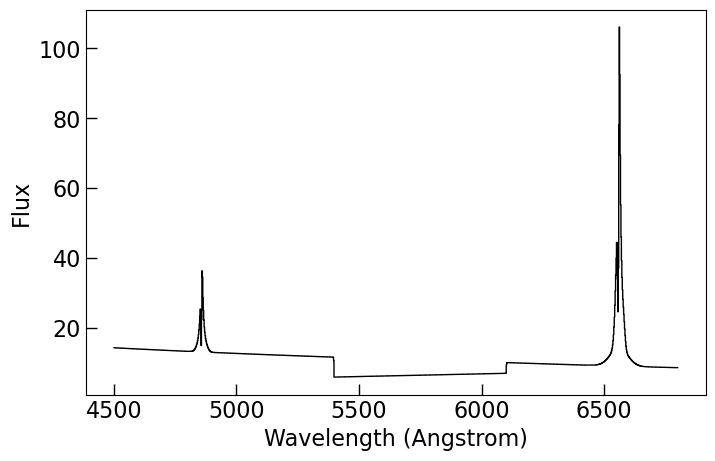

In [2]:
spec = np.loadtxt('data/mock_data_j0925_hab.txt')
wave_org = spec[:, 0]
flux_org = spec[:, 1]
wave = np.linspace(wave_org.min(), wave_org.max(), len(wave_org))
flux = np.interp(wave, wave_org, flux_org)

fig, ax = plt.subplots(figsize=(8, 5))
ax.step(wave, flux, color='k', lw=1)
ax.set_xlabel('Wavelength (Angstrom)', fontsize=16)
ax.set_ylabel('Flux', fontsize=16)
plt.show()

<Line_MultiGauss(amp_c=40.39916659, dv_c=-174.84185059, sigma_c=420.41637568, wavec=6562.819, amp_w0=0.13259796, dv_w0=100.89526028, sigma_w0=1577.77712315, amp_w1=0.23607091, dv_w1=817.89851029, sigma_w1=344.84950574, name='Broad H$\\alpha$')>
<WindowedPowerLaw1D(amplitude=9.03759604, x_0=6550., alpha=1.46368102, x_min=6100., x_max=6800., name='Cont Ha')>
<Line_Absorption(tau_0=48.4772839, dv=-128.40762531, sigma=64.36734456, Cf=0.82404548, wavec=6562.819, name='Abs. H$\\alpha$')>
<Line_template(amplitude=87.82889047, dv=-6.42239047, wavec=6562.819, name='nHalpha')>
<Line_MultiGauss(amp_c=7.67612206, dv_c=-125.09176997, sigma_c=361.18912248, wavec=4861.333, amp_w0=1., dv_w0=71.61287743, sigma_w0=798.94585156, name='Broad H$\\beta$')>
<WindowedPowerLaw1D(amplitude=12.34477938, x_0=5100., alpha=1.16185565, x_min=4500., x_max=5400., name='Cont Hb')>
<Line_Absorption(tau_0=6.79905805, dv=-128.40762531, sigma=64.36734456, Cf=0.82404548, wavec=4861.333, name='Abs. H$\\beta$')>
<Line_templat

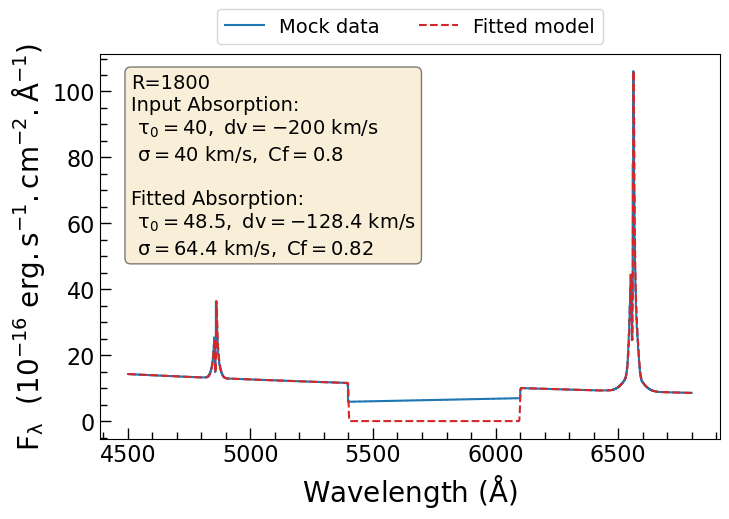

In [4]:
# Read the templates
temp_sii = np.loadtxt('data/J0925_sii.txt')
velc_temp = temp_sii[:, 0]
flux_temp = temp_sii[:, 1]

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
label_bHa = f"Broad {label_dict['Halpha']}"
label_bHb = f"Broad {label_dict['Hbeta']}"
label_bHg = f"Broad {label_dict['Hgamma']}"
label_aHa = f"Abs. {label_dict['Halpha']}"
label_aHb = f"Abs. {label_dict['Hbeta']}"
label_aHg = f"Abs. {label_dict['Hgamma']}"
line_windows = [(6100, 6800), (4500, 5400)]

cont_ha = sagan.WindowedPowerLaw1D(amplitude=9.66507821, x_0=6550., alpha=1.34015076, 
                                   x_min=line_windows[0][0], x_max=line_windows[0][1], 
                                   name=f"Cont Ha")

bha = sagan.Line_MultiGauss(n_components=3, amp_c=46.88225475, dv_c=-98.13526293, sigma_c=367.24691732, 
                            amp_w0=0.20963328, dv_w0=5.16688386, sigma_w0=1156.79725753, 
                            amp_w1=0.13066547, dv_w1=757.06663417, sigma_w1=137.96377124,
                            wavec=wave_dict['Halpha'], name=label_bHa)
nha = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=55.04786137, dv=0, 
                          wavec=wave_dict['Halpha'], name='nHalpha')
aha = sagan.Line_Absorption(tau_0=50, dv=-100, sigma=70, 
                            Cf=0.5, wavec=wave_dict['Halpha'], name=label_aHa)

# Hbeta
cont_hb = sagan.WindowedPowerLaw1D(amplitude=12.95136098, x_0=5100., alpha=1.07365361, 
                                   x_min=line_windows[1][0], x_max=line_windows[1][1], 
                                   name=f'Cont Hb')
bhb = sagan.Line_MultiGauss(n_components=2, amp_c=8.55861792, dv_c=-104.2687552, sigma_c=325.41295794, 
                            amp_w0=1., dv_w0=4.9841119, sigma_w0=745.59448144, 
                            wavec=wave_dict['Hbeta'], name=label_bHb)
nhb = sagan.Line_template(template_velc=velc_temp, template_flux=flux_temp, amplitude=12.13353965, dv=0, 
                          wavec=wave_dict['Hbeta'], name='nHbeta')
ahb = sagan.Line_Absorption(tau_0=0.55, dv=64.5, sigma=129.21, Cf=0.5, 
                            wavec=wave_dict['Hbeta'], name=label_aHb)

resolving_power = 1800
m_ha = (bha + cont_ha) * aha
m_ha = sagan.convolve_lsf(m_ha, wavec=m_ha[label_bHa].wavec, resolving_power=resolving_power)
m_hb = (bhb + cont_hb) * ahb
m_hb = sagan.convolve_lsf(m_hb, wavec=m_hb[label_bHb].wavec, resolving_power=resolving_power)
m_init = m_ha + nha + m_hb + nhb

# Use find_submodel_recursive for accessing nested models after convolution
# (models are nested inside the convolved wrappers)
#abs_ha = sagan.find_submodel_recursive(m_init, label_aHa)
#abs_hb = sagan.find_submodel_recursive(m_init, label_aHb)

m_hb[label_aHb].dv.tied = sagan.tie_Absorption_dv(label_aHa)
m_hb[label_aHb].sigma.tied = sagan.tie_Absorption_sigma(label_aHa)
m_hb[label_aHb].Cf.tied = sagan.tie_Absorption_Cf(label_aHa)
m_hb[label_aHb].tau_0.tied = sagan.tie_Absorption_tau0(label_aHa, ratio=7.13)

fitter = fitting.LevMarLSQFitter()
m_fit = fitter(m_init, wave, flux)

for m in m_fit:
    print(m.__repr__())


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.step(wave, flux, label='Mock data', color='C0')
ax.plot(wave, m_fit(wave), label='Fitted model', color='C3', linestyle='--')

# Access fitted absorption parameters using find_submodel_recursive
abs_ha_fitted = m_fit[label_aHa]

# Use text to show the input and output absorption parameters
textstr = '\n'.join((
    rf'R={1800}',
    r'Input Absorption:',
    rf'$\rm \ \tau_0={40},\ dv={-200}\ km/s$',
    rf'$\rm \ \sigma={40}\ km/s,\ Cf={0.8}$',
    '',
    r'Fitted Absorption:',
    rf'$\rm \ \tau_0={abs_ha_fitted.tau_0.value:.1f},\ dv={abs_ha_fitted.dv.value:.1f}\ km/s$',
    rf'$\rm \ \sigma={abs_ha_fitted.sigma.value:.1f}\ km/s,\ Cf={abs_ha_fitted.Cf.value:.2f}$',
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.set_xlim(4700, 4900)
#ax.set_xlim(6500, 6800)
ax.set_xlabel(r'$\rm Wavelength\ (\AA)$', fontsize=20)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-16} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=20)
ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)
ax.minorticks_on()
plt.show()